<div align="center">
    <font size=8>TME 2</font>
</div>
<h1>PARTIE 1</h1>
<br/>
<div align="right">
    ABITBOL Yossef 3804139 , KOSTADINOVIC Nikola 3801695
</div>

# Outlook #

In this colab we will investigate the **value iteration** and **policy iteration** algorithms in a maze environment.

# Installation #

In [1]:
!apt-get install ffmpeg

zsh:1: command not found: apt-get


In [2]:
!pip install git+https://github.com/osigaud/SimpleMazeMDP

  Cloning https://github.com/osigaud/SimpleMazeMDP to /private/var/folders/3s/q8k8qf953g1fgcw6gk1v48fh0000gn/T/pip-req-build-st8ohwah
  Running command git clone --filter=blob:none --quiet https://github.com/osigaud/SimpleMazeMDP /private/var/folders/3s/q8k8qf953g1fgcw6gk1v48fh0000gn/T/pip-req-build-st8ohwah
  Resolved https://github.com/osigaud/SimpleMazeMDP to commit b4be43c9fddbc46d42efe357ffd02b11bbc258d2
  Preparing metadata (setup.py) ... done


In [3]:
import os
import time
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt

from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp

# For visualization
os.environ["VIDEO_FPS"] = "5"

Matplotlib backend: module://ipykernel.pylab.backend_inline


# Agents and MDPs #


A reinforcement learning agent interacts with an environment represented as a Markov Decision Process (MDP). It is defined by a tuple $(S, A, P, r, \gamma)$ where $S$ is the state space, $A$ is the action space, $P(state_t, action_t, state_{t+1})$ is the transition function, $r(state_t, action_t)$ is the reward function and $\gamma \in [0, 1]$ is the discount factor.



In what follows we import code to create an MDP corresponding to a random maze (see https://github.com/osigaud/SimpleMazeMDP for documentation).

In [4]:
from mazemdp import create_random_maze

mdp = create_random_maze(10, 10, 0.2)

# Dynamic programming #


The goal of an RL agent is to find the optimal behaviour, defined by a policy $\pi$ that assigns an action (or distribution over actions) to each state so as to maximize the agent's total expected reward. In order to estimate how good a state is, either a state value function $V(x)$ or a state-action value function $Q(x,u)$ is used.

Dynamic programming algorithms are used for planning, they require a full knowledge of the MDP from the agent (in contrast to "true" RL where the agent does not know the transition and reward functions).
They find the optimal policy by computing a value function $V$ or an action-value function $Q$ over the state space or state-action space of the given MDP. **Value iteration** and **policy iteration** are two standard dynamic programming algorithms. You should study both of them using both $V$ and $Q$, as these algorithms contain the basic building blocks for most RL algorithms.


## Value Iteration ##

### Value Iteration with the V function ###



When using the $V$ function, **value iteration** aims at finding the optimal values $V^*$ based on the Bellman Optimality Equation:
$$V^*(s) = \max_a \big[ r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^*(y) \big],$$

where:

*   $r(s, a)$ is the reward obtained from taking action $a$ in state $s$,
*   $P(s, a, y)$ is the probability of reaching state $y$ when taking action $a$ in state $s$, 
*   $\gamma \in [0,1]$ is a discount factor defining the relative importance of long term rewards over short term ones (the closer to 0, the more the agent focuses on immediate rewards).

In practice, we start with an initial value function $V^0$ (for instance, the values of all states are 0), and then we iterate for all states $s$

$$V^{i+1}(s) = \max_a \big[ r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^i(y) \big],$$

until the values converge, that is $\forall s, V^{i+1}(s) \approx V^i(s)$. It is shown that at convergence, $\forall s, V^i(s)= V^*(s)$.

To visualize the policy obtained from **value iteration**, we need to first define the `get_policy_from_V()` function

In [5]:
def get_policy_from_v(mdp: Mdp, v: np.ndarray) -> np.ndarray:
    # Outputs a policy given the state values
    policy = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        v_temp = []
        for u in mdp.action_space.actions:
            if x not in mdp.terminal_states:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
            else:  # if the state is final, then we only take the reward into account
                v_temp.append(mdp.r[x, u])
        policy[x] = np.argmax(v_temp)
    return policy


The `value_iteration_v(mdp)` function below provides the code of **value iteration** using the $V$ function. It is given as an example from which you can derive other instances of dynamic programming algorithms. Look at it more closely, this will help for later questions:

* you can ignore the `mdp.new_render()` and `mdp.render(...)` functions which are here to provide the visualization of the iterations.
* find in the code the loop over states, the main loop that performs these updates until the values don't change significantly anymore, the main update equation. Found them? OK, you can continue...


In [6]:
# ------------------------- Value Iteration with the V function ----------------------------#
# Given a MDP, this algorithm computes the optimal state value function V
# It then derives the optimal policy based on this function
# This function is given


def value_iteration_v(mdp: Mdp, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # Value Iteration using the state value v
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    stop = False

    if render:
        mdp.new_render("Value iteration V")

    while not stop:
        v_old = v.copy()
        if render:
            mdp.render(v, title="Value iteration V")

        for x in range(mdp.nb_states):  # for each state x
            # Compute the value of the state x for each action u of the MDP action space
            v_temp = []
            for u in mdp.action_space.actions:
                if x not in mdp.terminal_states:
                    # Process sum of the values of the neighbouring states
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ = summ + mdp.P[x, u, y] * v_old[y]
                    v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
                else:  # if the state is final, then we only take the reward into account
                    v_temp.append(mdp.r[x, u])

                    # Select the highest state value among those computed
            v[x] = np.max(v_temp)

        # Test if convergence has been reached
        if (np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    if render:
        policy = get_policy_from_v(mdp, v)
        mdp.render(v, policy, title="Value iteration V")

    return v, v_list


Let us run it on the previously defined MDP

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


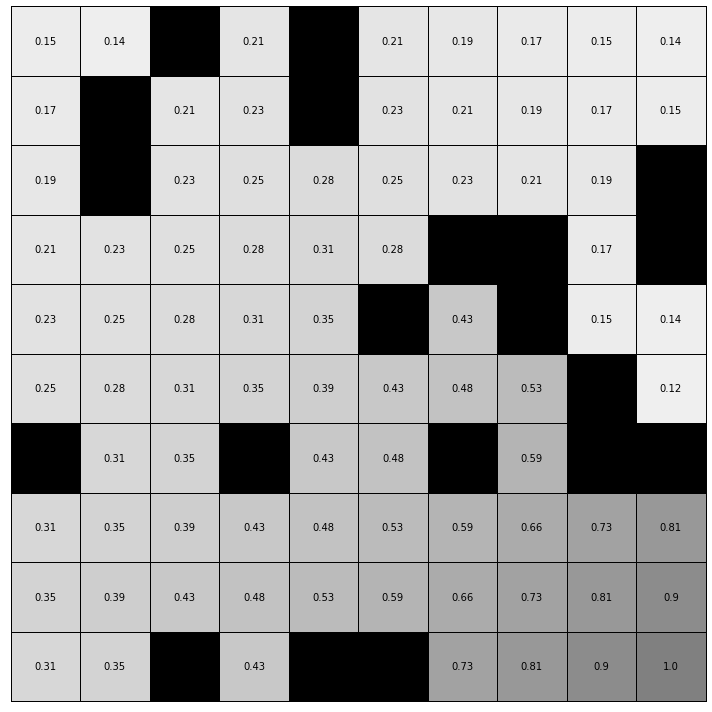

In [7]:
v, v_list = value_iteration_v(mdp, render=True)

In [8]:
show_videos("videos/", prefix="ValueiterationV")

### Value iteration with the $Q$ function ###


The state-action value function $Q^{\pi}(s,a)$ defines the value of being in state $s$, taking action $a$ then following policy $\pi$. The Bellman Optimality Equation for $Q^*$ is
$$ Q^*(s,a) =  r(s,a) + \gamma \sum_{y} P(s,a,y) \max_{a'}Q^*(y,a'). $$ 


**Question:** By taking inspiration from the `value_iteration_v(mdp)` function above, fill the blank (given with '\#Q[x,u]=...') in the code of `value_iteration_q(mdp)`.

In [9]:

# ------------------------- Value Iteration with the Q function ----------------------------#
# Given a MDP, this algorithm computes the optimal action value function Q
# It then derives the optimal policy based on this function


def value_iteration_q(mdp: Mdp, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    stop = False

    if render:
        mdp.new_render("Value iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.render(q, title="Value iteration Q")

        for x in range(mdp.nb_states):
            for u in mdp.action_space.actions:
                if x in mdp.terminal_states:
                    q[x, :] = 1
                else:
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ += mdp.gamma * mdp.P[x,u,y]*np.max(qold[y])
                    q[x, u] = mdp.r[x,u] + summ

        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    if render:
        mdp.render(q, title="Value iteration Q")
    return q, q_list


Once you are done, run it.

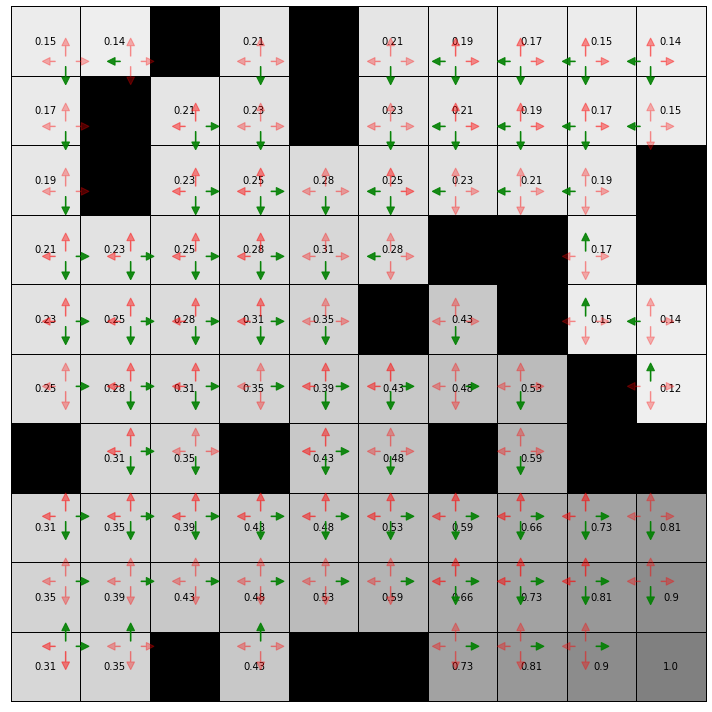

In [10]:
q, q_list = value_iteration_q(mdp, render=True)

In [11]:
show_videos("videos/", prefix="ValueiterationQ")

## Policy Iteration ##


The **policy iteration** algorithm is more complicated than **value iteration**.
Given a MDP and a policy $\pi$, **policy iteration** iterates the following steps: 

*   Evaluate policy $\pi$: compute $V$ or $Q$ based on the policy $\pi$;
*   Improve policy $\pi$: compute a better policy based on $V$ or $Q$.

This process is repeated until convergence, i.e. when the policy cannot be improved anymore.


### Policy iteration with the $V$ function ###

When using $V$, $V^{\pi}(s)$ is the expected return when starting from state $s$ and following policy $\pi$. It is processed based on the Bellman Optimality Equation for deterministic policies:

$$V^\pi(s) = r(s, \pi(s)) + \gamma \sum_{y \in S}P(s, \pi(s), y)V^\pi(y),$$


where:

*   $\pi$ is a deterministic policy, meaning that in a state $s$, the agent always selects the same action,
*   $V^\pi(y)$ is the value of the state $y$ under policy $\pi$.


Thus, given a policy $\pi$, one must first compute its value function $V^\pi(s)$ for all states $s$ iterating the Bellman Optimality Equation until convergence, that is using **value iteration**.
Then, one must determine if policy $\pi$ can be improved based on $V$. For that, in each state $s$, one can compute the Q-value $Q(s,a)$ of applying action $a$ and then following policy $\pi$ based on the just computed $V^\pi$, and replace the action $\pi(s)$ with $\arg\max_a Q(s,a)$.



In order to facilitate the coding of **policy iteration** algorithms, we first define a set of useful functions.

The `improve_policy_from_v(mdp, v, policy)` function is very similar to the `get_policy_from_v(v)` function which was given above. The main difference is that it takes a policy as argument and improves this policy when possible, thus is is more in the spirit of the `policy improvement` step of **policy iteration**. But both functions can be used interchangeably.

The functions `evaluate_one_step_v(mdp, v, policy)`, where `mdp` is a given MDP, `v` is some value function in this MDP and `policy` is some policy and the function `evaluate_v(mdp, policy)` are also given. These functions are used to build the value function $V^\pi$ corresponding to policy $\pi$.


In [12]:
def improve_policy_from_v(mdp: Mdp, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Improves a policy given the state values
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        v_temp = np.zeros(mdp.action_space.size)
        for u in mdp.action_space.actions:
            if x not in mdp.terminal_states:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp[u] = mdp.r[x, u] + mdp.gamma * summ
            else:  # if the state is final, then we only take the reward into account
                v_temp[u] = mdp.r[x, u]

        for u in mdp.action_space.actions:
            if v_temp[u] > v_temp[policy[x]]:
                policy[x] = u
    return policy

In [13]:
def evaluate_one_step_v(mdp: Mdp, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    v_new = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            # Process sum of the values of the neighbouring states
            summ = 0
            for y in range(mdp.nb_states):
                summ = summ + mdp.P[x, policy[x], y] * v[y]
            v_new[x] = mdp.r[x, policy[x]] + mdp.gamma * summ
        else:  # if the state is final, then we only take the reward into account
            v_new[x] = mdp.r[x, policy[x]]
    return v_new

In [14]:
def evaluate_v(mdp: Mdp, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    stop = False
    while not stop:
        vold = v.copy()
        v = evaluate_one_step_v(mdp, vold, policy)

        # Test if convergence has been reached
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
    return v

To perform **policy iteration** we also need an initial random policy.

In [15]:
from mazemdp import random_policy

**Question:** By using the above functions, fill the code of the `policy_iteration_v(mdp)` function below.

In [16]:
# ------------------------- Policy Iteration with the V function ----------------------------#
# Given a MDP, this algorithm simultaneously computes the optimal state value function V and the optimal policy

def policy_iteration_v(mdp: Mdp, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)

    stop = False
    if render:
        mdp.new_render("Policy iteration V")
    while not stop:
        vold = v.copy()
        # Step 1 : Policy Evaluation
        v = evaluate_v(mdp, policy)
        if render:
            mdp.render(v, title="Policy iteration V")
            mdp.plotter.render_pi(policy)

        # Step 2 : Policy Improvement
        policy = improve_policy_from_v(mdp,v,policy)

        # Check convergence
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    if render:
        mdp.render(v, title="Policy iteration V")
        mdp.plotter.render_pi(policy)
    return v, v_list

And finally run it.

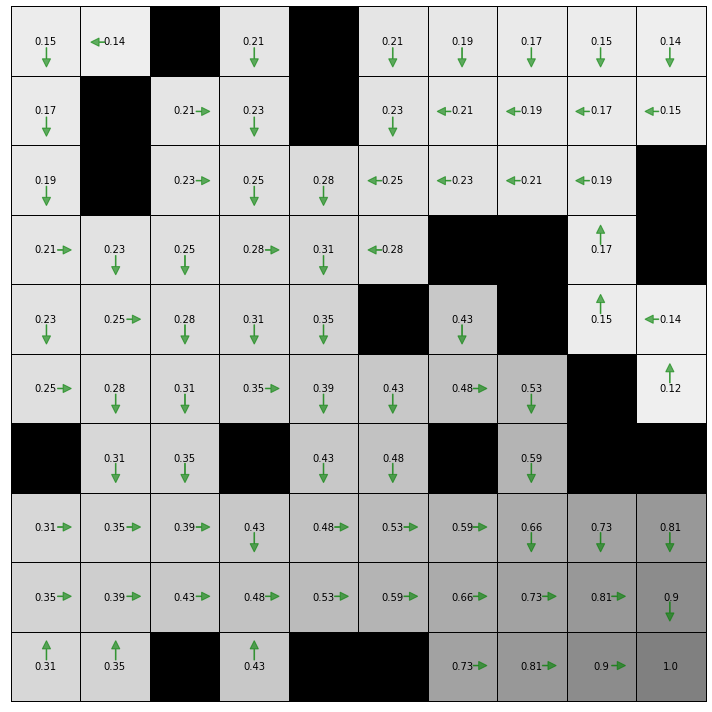

In [17]:
v, v_list = policy_iteration_v(mdp, render=True)

In [18]:
show_videos("videos/", prefix="PolicyiterationV")

### Policy iteration with the $Q$ function ###


The **policy iteration** algorithm with the $Q$ function is the same as with the $V$ function, but the policy improvement step is more straightforward.

When using $Q$, the Bellman Optimality Equation with deterministic policy $\pi$ for $Q$ becomes: 
$$Q^{\pi}(s,a) = r(s,a) + \gamma \sum_{y \in S}P(s,a,y)Q^{\pi}(y,\pi(y)).$$

The policy can then be updated as follows:
$$\pi^{(t+1)}(s) = \arg\max_aQ^{\pi^{(t)}}(s,a).$$


First, we need to determine a policy from the $Q$ function.

**Question:**  fill the `get_policy_from_q(q)` function, where $q$ is the state-action value function.

In [19]:
?np.argmax

In [20]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
  return np.argmax(q,1)

**Question:** By drawing inspiration on the functions give with the $v$ function, fill the code of the `evaluate_one_step_q(mdp, q, policy)` function below, where $q$ is some action value function, and the `evaluate_q(mdp, policy)` function.

In [21]:
def evaluate_one_step_q(mdp: Mdp, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        for u in mdp.action_space.actions:
            if x not in mdp.terminal_states:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                  summ = summ + mdp.P[x,u,y] * q[y, policy[y]]
                qnew[x,u] = mdp.r[x,u] + mdp.gamma * summ 
            else:  # if the state is final, then we only take the reward into account
                qnew[x, u] = mdp.r[x,u]
    return qnew

In [22]:
def evaluate_q(mdp: Mdp, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    stop = False
    while not stop:
        qold = q.copy()
        q = evaluate_one_step_q(mdp,qold, policy)

        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    return q

**Question:** By using the above functions, fill the code of the `policy_iteration_q(mdp)` function below.

In [23]:
# ------------------------- Policy Iteration with the Q function ----------------------------#
# Given a MDP, this algorithm simultaneously computes the optimal action value function Q and the optimal policy

def policy_iteration_q(mdp: Mdp, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False

    if render:
        mdp.new_render("Policy iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.render(q, title="Policy iteration Q")

        # Step 1 : Policy evaluation
        q = evaluate_q(mdp, policy)

        # Step 2 : Policy improvement
        policy = get_policy_from_q(q)

        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    if render:
        mdp.render(q, get_policy_from_q(q), title="Policy iteration Q")
    return q, q_list


Finally, run it.

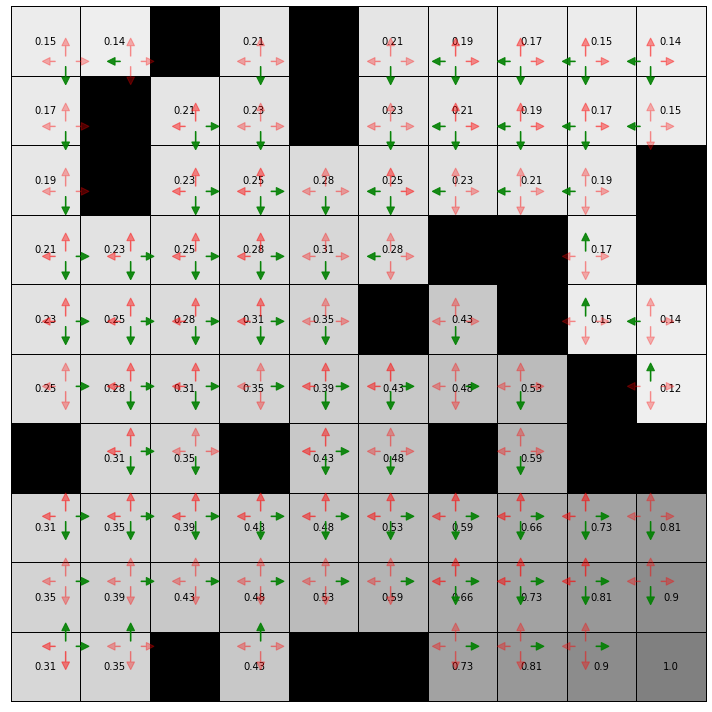

In [24]:
q, q_list = policy_iteration_q(mdp, render=True)

In [25]:
show_videos("videos/", prefix="PolicyiterationQ")

### Study part: Experimental comparisons

We will now compare the efficiency of the various dynamic programming methods using either the $V$ or the  $Q$ functions.

In all your dymanic programming functions, add code to count the number of iterations and the number of elementary $V$ or $Q$ updates. Use the provided `mazemdp.Chrono` class to measure the time taken. You may generate various mazes of various sizes to figure out the influence of the maze topology.

Build a table where you compare the various dymanic programming functions in terms of iterations, elementary operations and time taken.

You can run the `plot_convergence_vi_pi(...)` function provided below to visualize the convergence of the various algorithms.


In [26]:

# -------- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax ----------#


def plot_convergence_vi_pi(m, render):
    v, v_list1 = value_iteration_v(m, render)
    q, q_list1 = value_iteration_q(m, render)
    v, v_list2 = policy_iteration_v(m, render)
    q, q_list2 = policy_iteration_q(m, render)

    plt.plot(range(len(v_list1)), v_list1, label='value_iteration_v')
    plt.plot(range(len(q_list1)), q_list1, label='value_iteration_q')
    plt.plot(range(len(v_list2)), v_list2, label='policy_iteration_v')
    plt.plot(range(len(q_list2)), q_list2, label='policy_iteration_q')

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of V or Q value')
    plt.legend(loc='upper right')
    plt.savefig("comparison_DP.png")
    plt.title("Comparison of convergence rates")
    plt.show()

**Question:** Run the code below and visualize the results of the different algorithms

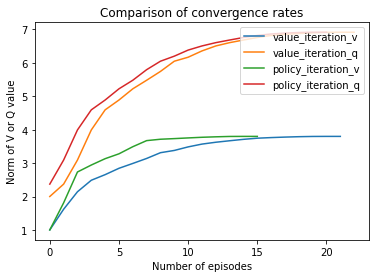

In [27]:
plot_convergence_vi_pi(mdp, False)


Given the results above, discuss the relative computational efficiency of these methods.

Ci-dessus, nous exécutons plusieurs fois nos quatres algorithmes de programmation dynamique pour calculer leur nombre moyen d'itérations, leur nombre de mises à jour élémentaires ainsi que leur temps d'exécution.

In [32]:
def compare_algorithm(n, m):
    value_iteration_v_time, value_iteration_q_time, policy_iteration_v_time, policy_iteration_q_time = 0, 0, 0, 0
    total_value_iteration_v_nb_iteration, total_value_iteration_v_nb_update = 0, 0
    total_value_iteration_q_nb_iteration, total_value_iteration_q_nb_update = 0, 0
    total_policy_iteration_v_nb_iteration, total_policy_iteration_v_nb_update = 0, 0
    total_policy_iteration_q_nb_iteration, total_policy_iteration_q_nb_update = 0, 0

    for _ in range(n):
        # print(_)
        # Value iteration with V function
        start_time = time.time()
        _, _, value_iteration_v_nb_iteration, value_iteration_v_nb_update  = value_iteration_v(m, render=False)
        value_iteration_v_time += time.time() - start_time
        total_value_iteration_v_nb_iteration += value_iteration_v_nb_iteration
        total_value_iteration_v_nb_update += value_iteration_v_nb_update

        # Value iteration with Q function
        start_time = time.time()
        _, _, value_iteration_q_nb_iteration, value_iteration_q_nb_update = value_iteration_q(m, render=False)
        value_iteration_q_time += time.time() - start_time
        total_value_iteration_q_nb_iteration += value_iteration_q_nb_iteration
        total_value_iteration_q_nb_update += value_iteration_q_nb_update

        # Policy iteration with V function
        start_time = time.time()       
        _, _, policy_iteration_v_nb_iteration, policy_iteration_v_nb_update = policy_iteration_v(m, render=False)
        policy_iteration_v_time += time.time() - start_time
        total_policy_iteration_v_nb_iteration += policy_iteration_v_nb_iteration
        total_policy_iteration_v_nb_update += policy_iteration_v_nb_update
        
        # Policy iteration with Q function
        start_time = time.time()
        _, _, policy_iteration_q_nb_iteration, policy_iteration_q_nb_update = policy_iteration_q(m, render=False)
        policy_iteration_q_time += time.time() - start_time
        total_policy_iteration_q_nb_iteration += policy_iteration_q_nb_iteration
        total_policy_iteration_q_nb_update += policy_iteration_q_nb_update

    print(f"Value iteration with V function:\nAverage number of iteration: {int(total_value_iteration_v_nb_iteration / n)}\
    \nAverage number of elementary V update: {int(total_value_iteration_v_nb_update / n)}\
    \nAverage run time: {value_iteration_v_time / n}")

    print(f"Value iteration with Q function:\nAverage number of iteration: {int(total_value_iteration_q_nb_iteration / n)}\
    \nAverage number of elementary Q update: {int(total_value_iteration_q_nb_update / n)}\
    \nAverage run time: {value_iteration_q_time / n}")

    print(f"Policy iteration with V function:\nAverage number of iteration: {int(total_policy_iteration_v_nb_iteration / n)}\
    \nAverage number of elementary V update: {int(total_policy_iteration_v_nb_update / n)}\
    \nAverage run time: {policy_iteration_v_time / n}")

    print(f"Policy iteration with Q function:\nAverage number of iteration: {int(total_policy_iteration_q_nb_iteration / n)}\
    \nAverage number of elementary Q update: {int(total_policy_iteration_q_nb_update / n)}\
    \nAverage run time: {policy_iteration_q_time / n}")

In [33]:
compare_algorithm(20, mdp)

ValueError: not enough values to unpack (expected 4, got 2)

### Study part: Generalized Policy Iteration

Code the **generalized policy iteration** algorithm and study the influence of the number of evaluation steps between each improvement step

In [28]:
def generalized_policy_iteration_v(mdp, evaluation_step, render):
    v = np.zeros(mdp.nb_states) #on initialise à zéro
    list_v = []
    policy = random_policy(mdp)
    stop = False
    
    nb_iterations, nb_update_total = 0, 0
    
    if render:
        mdp.new_render("Policy Iteration V")
        
    while not stop:
        nb_iterations += 1
        v_old = v.copy()
        
        for _ in range(evaluation_step):
            v_new, nb_update_one_step = evaluate_one_step_v(mdp, v, policy)
            nb_update_total += nb_update_one_step
            v = v_new
            
        if render:
            mdp.render(v, title="Policy Iteration V")
            mdp.plotter.render_pi(policy)
            
        policy = improve_policy_from_v(mdp, v, policy)
        
        if(np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        
        list_v.append(np.linalg.norm(v))
        
        if render:
            mdp.render(v, title="Policy Iteration V")
            mdp.plotter.render_pi(policy)
        
    return v, list_v, nb_iterations, nb_update_total

ValueError: too many values to unpack (expected 2)

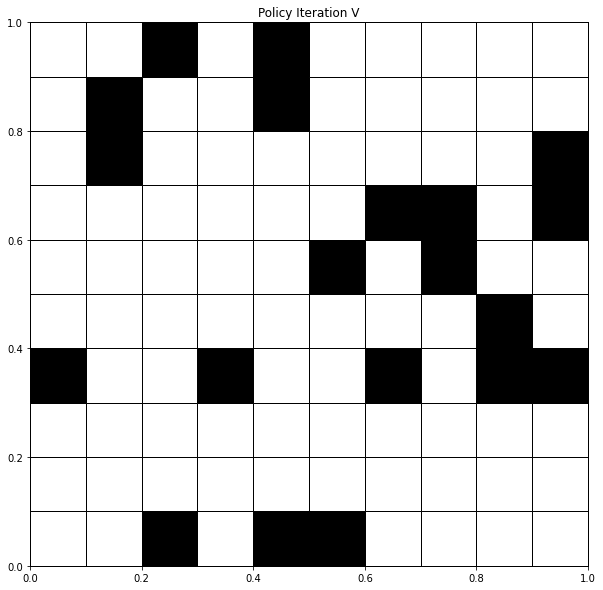

In [29]:
v, list_v, _, _ = generalized_policy_iteration_v(mdp, 10, True)

Nous allons faire la même pour Q maintenant:

In [ ]:
def generalized_policy_iteration_q(mdp, evaluation_step, render):
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    list_q = []
    policy = random_policy(mdp)

    stop = False

    nb_iteration, nb_update_total = 0, 0


    if render:
        mdp.new_render("Policy iteration Q")

    while not stop:
        q_old = q.copy()
        nb_iteration += 1

        if render:
            mdp.render(q, title="Policy iteration Q")
            
        for _ in range(evaluation_step):
            q_new, nb_update_one_step = evaluate_one_step_q(mdp, q, policy)
            nb_update_total += nb_update_one_step
            q = q_new
            
        policy = get_policy_from_q(q)
        
        if (np.linalg.norm(q - q_old)) <= 0.01:
            stop = True
        list_q.append(np.linalg.norm(q))

    if render:
        mdp.render(q, get_policy_from_q(q), title="Policy iteration Q")
    return q, list_q, nb_iterations, nb_update_total

In [ ]:
_,_,_,_ = generalized_policy_iteration_q(mdp, 5, True)

* Nous pouvons voir que les deux algorithmes d'itération de politique généralisés avec les fonctions V et Q convergent avec un petit nombre d'étapes d'évaluation.
    Comparons maintenant ces deux algorithmes avec les autres.

In [ ]:
def plot_convergence(m, render):
    v, v_list, _, _ = generalized_policy_iteration_v(m, 5,render)
    q, q_list, _, _ = generalized_policy_iteration_q(m, 5, render)

    plt.plot(range(len(v_list)), v_list, label='generalized_policy_iteration_v')
    plt.plot(range(len(q_list)), q_list, label='generalized_policy_iteration_q')

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of V or Q value')
    # plt.legend(loc='upper right')
    plt.savefig("comparison_DP.png")
    plt.title("Comparison of convergence rates")
    plt.show()

In [ ]:
plot_convergence(mdp, False)

* Nous avons ci-dessus, une figure qui trace la convergence de deux algorithmes d'itération de politique généralisés avec un pas d'évaluation de 5.
Comparons maintenant le nombre d'itération et le nombre de mise à jour élémentaire.

In [ ]:
def compare_generalized_algorithm(mdp, n, evaluation_step):
    policy_iteration_v_time, policy_iteration_q_time = 0, 0
    total_policy_iteration_v_nb_iteration, total_policy_iteration_v_nb_update = 0, 0
    total_policy_iteration_q_nb_iteration, total_policy_iteration_q_nb_update = 0, 0

    for _ in range(n):
        start_time = time.time()       
        _, _, policy_iteration_v_nb_iteration, policy_iteration_v_nb_update = generalized_policy_iteration_v(mdp, evaluation_step, render=False)
        policy_iteration_v_time += time.time() - start_time
        total_policy_iteration_v_nb_iteration += policy_iteration_v_nb_iteration
        total_policy_iteration_v_nb_update += policy_iteration_v_nb_update

        start_time = time.time()
        _, _, policy_iteration_q_nb_iteration, policy_iteration_q_nb_update = generalized_policy_iteration_q(mdp, evaluation_step, render=False)
        policy_iteration_q_time += time.time() - start_time
        total_policy_iteration_q_nb_iteration += policy_iteration_q_nb_iteration
        total_policy_iteration_q_nb_update += policy_iteration_q_nb_update

    print(f"Policy iteration with V function:\nAverage number of iteration: {int(total_policy_iteration_v_nb_iteration / n)}\
    \nAverage number of elementary V update: {int(total_policy_iteration_v_nb_update / n)}\
    \nAverage run time: {policy_iteration_v_time / n}")

    print(f"Policy iteration with Q function:\nAverage number of iteration: {int(total_policy_iteration_q_nb_iteration / n)}\
    \nAverage number of elementary Q update: {int(total_policy_iteration_q_nb_update / n)}\
    \nAverage run time: {policy_iteration_q_time / n}")

In [ ]:
compare_generalized_algorithm(mdp,20,1)

In [30]:
def plot_evaluation_step(mdp):
    steps = range(1, 100)
    run_time_v, run_time_q = [], []
    nb_iteration_v_list, nb_iteration_q_list = [], []
    nb_update_v_list, nb_update_q_list = [], []

    for step in steps:
        start_time = time.time()
        _, _, nb_iteration_v, nb_update_v = generalized_policy_iteration_v(mdp, step, False)
        run_time_v.append(time.time() - start_time)
        nb_iteration_v_list.append(nb_iteration_v)
        nb_update_v_list.append(nb_update_v)

        start_time = time.time()
        _, _, nb_iteration_q, nb_update_q = generalized_policy_iteration_q(mdp, step, False)
        run_time_q.append(time.time() - start_time)
        nb_iteration_q_list.append(nb_iteration_q)
        nb_update_q_list.append(nb_update_q)

    plt.figure()
    plt.plot(steps, run_time_v, label="Run time with V function")
    plt.plot(steps, run_time_q, label="Run time with Q function")
    plt.xlabel("Evaluation step")
    plt.ylabel("Run time")
    plt.title("Effect of evaluation step on running time")
    plt.legend()

    plt.figure()
    plt.plot(steps, nb_iteration_v_list, label="Number of iteration with V function")
    plt.plot(steps, nb_iteration_q_list, label="Number of iteration with Q function")
    plt.xlabel("Evaluation step")
    plt.ylabel("Number of iteration")
    plt.title("Effect of evaluation step on number of iteration")
    plt.legend()  

    plt.figure()
    plt.plot(steps, nb_update_v_list, label="Number of elementary update with V function")
    plt.plot(steps, nb_update_q_list, label="Number of elementary update with Q function")
    plt.xlabel("Evaluation step")
    plt.ylabel("Number of elementary update")
    plt.title("Effect of evaluation step on number of number of elementary update")
    plt.legend() 

In [31]:
plot_evaluation_step(mdp)

ValueError: too many values to unpack (expected 2)